In [1]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
import preprocess
import cv2
import scipy.spatial as sp


def show_images(imgs, columns=4, rows=5, figsize=(10,10)):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows +1):
        if i > len(imgs):
            break
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i-1])
    plt.show()

/home/xfu5/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xfu5/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xfu5/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xfu5/anaconda3/envs/tf-gpu/lib/python3.6/site-

### Get Real Images

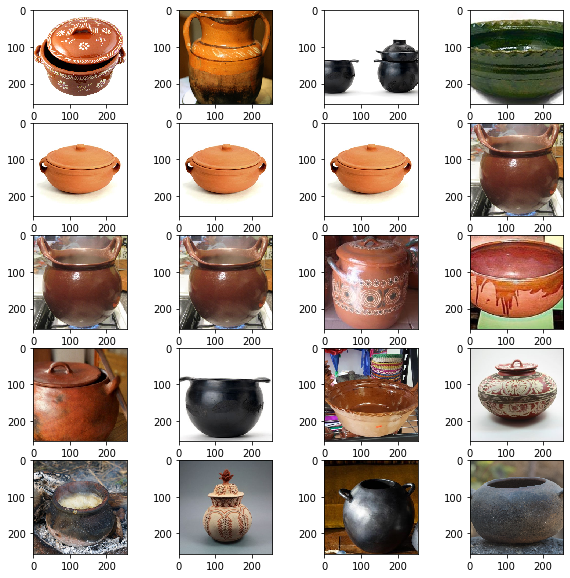

In [2]:
image_files = preprocess.loadImages('/media/data_cifs/xfu5/preprocessed_images/', 'Cazuela')
real_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)for path in image_files])
show_images(real_images)

### Generate Images from Final Snapshot of model

In [3]:
tflib.init_tf()
with open('/media/data_cifs/xfu5/results/00000-sgan-Cazuela-1gpu/network-snapshot-009726.pkl', 'rb') as f:
        generator, discriminator, Gs = pickle.load(f)

In [15]:
# Pick latent vector.
N = 100 # number of images generated 
rnd = np.random.RandomState(1234)
latents = rnd.randn(N, Gs.input_shape[1])

# Generate image.
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
gen_images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

In [16]:
gen_images.shape

(100, 256, 256, 3)

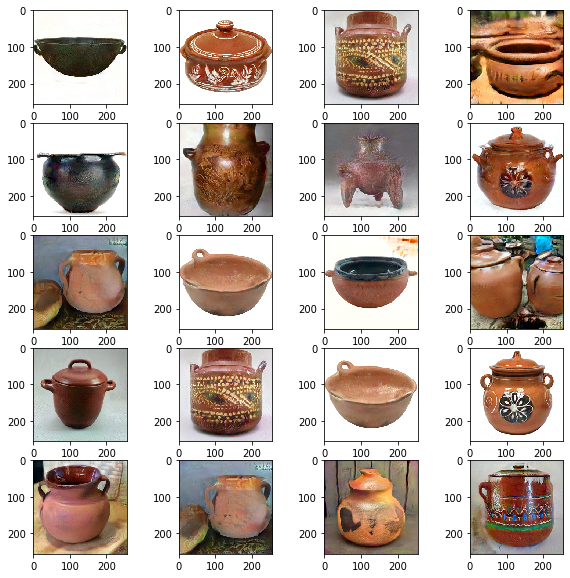

In [19]:
show_images(gen_images)

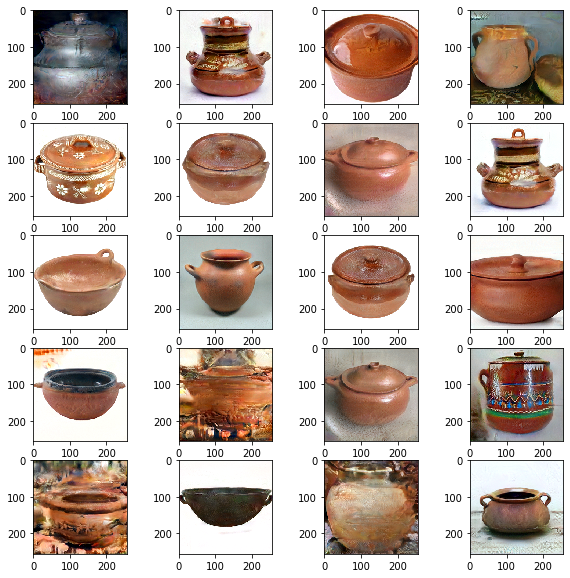

In [67]:
# Flip the image along the vertical line
show_images(gen_images[:,:,::-1,:])

### Flatten both generated and real images to compare cosine similarity

In [22]:
gen_images_flatten = gen_images.reshape(gen_images.shape[0], -1)
gen_images_r_flatten = gen_images[:,:,::-1,:].reshape(gen_images.shape[0], -1)
real_images_flatten = real_images.reshape(real_images.shape[0],-1)
assert (gen_images_flatten.shape[1] == real_images_flatten.shape[1])

### Find unique images generated

In [69]:
gen_images_unique = []

for g in gen_images_flatten:
    if len(gen_images_unique) == 0:
        gen_images_unique.append(g)
    else:
        if np.sum((1-sp.distance.cdist([g], gen_images_unique, 'cosine'))>0.99) == 0:
            gen_images_unique.append(g)

gen_images_unique = np.array(gen_images_unique)
len(gen_images_unique)

59

### Find generated images that are identical to real images with cosine similarity

In [23]:
t = 0.99 # threshold of cosine similarity for considering 2 images as identical
cos_sims = 1 - sp.distance.cdist(gen_images_flatten, real_images_flatten, 'cosine')
cos_sims_r = 1 - sp.distance.cdist(gen_images_r_flatten, real_images_flatten, 'cosine')
# Find images that are identical to training images to calculate novelty
final_cos_sims = np.logical_or(cos_sims>t, cos_sims_r>t)
novelty = 1 - np.sum(np.sum(final_cos_sims,axis=1)>0)/final_cos_sims.shape[0]
print(novelty)

0.53


In [24]:
# Get index of identical images from fake and real images
same_inds_gen, same_inds_real = np.where(final_cos_sims>t)

In [20]:
def show_same_images(inds_gen, inds_real, columns=2, rows=5, figsize=(5,10)):
    fig=plt.figure(figsize=figsize)
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title("Generated")
        if i == 1:
            plt.title("Real")
        if i % 2==0:
            plt.imshow(gen_images[inds_gen[i//2]])
        else:
            plt.imshow(real_images[inds_real[i//2]])
    plt.show()

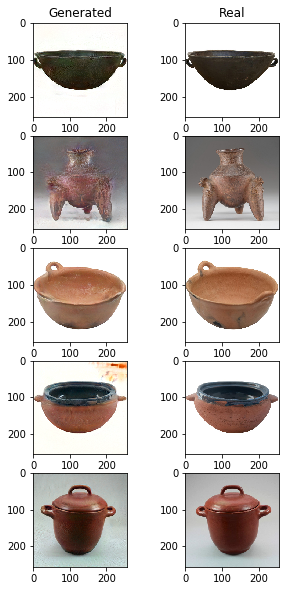

In [25]:
show_same_images(same_inds_gen, same_inds_real)

### High-quality Images Generated

In [14]:
good_inds = [3,4,5,7,31,42,69,88,95]
len(good_inds)

9

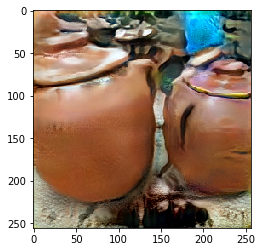

In [15]:
plt.imshow(gen_images[11])

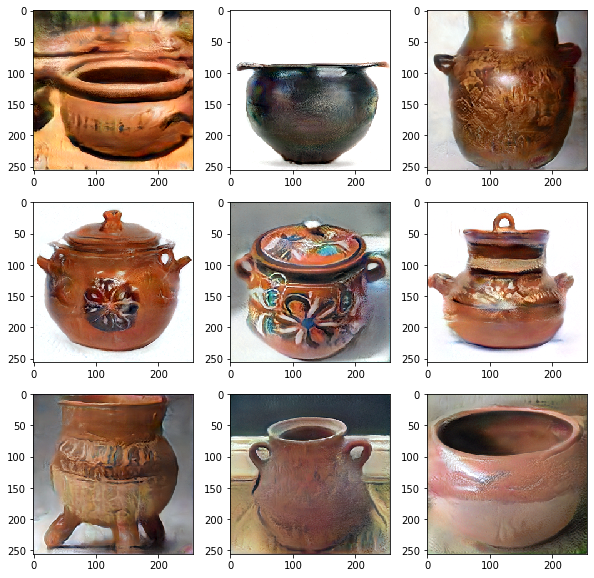

In [16]:
show_images(gen_images[good_inds],3,3)

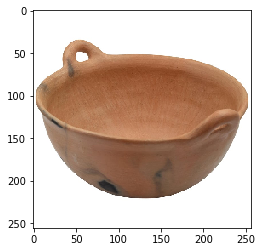

In [55]:
plt.imshow(real_images[354])

### Record and plot the FID along the training process

Text(0.5, 1.0, 'FID scores')

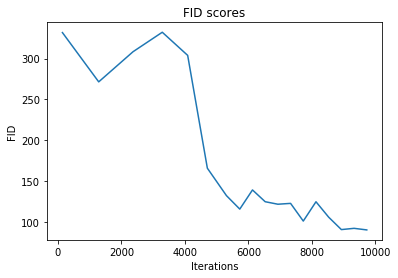

In [123]:
x = [140, 1283, 2364, 3285, 4085, 4705, 5306, 5726, 6126, 6526, 6926, 7326, 7726, 8126, 8526, 8926, 9326, 9726]
y = [331.6438, 271.5049, 308.2774, 332.0485, 303.8192, 
     166.1467, 132.6916, 116.2402, 139.6151, 125.2603, 
     122.1961, 123.2251, 101.6447, 125.2024, 106.3816, 
     91.2471, 92.7786, 90.8457]
plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel('FID')
plt.title('FID scores')

### Monte Carlo Simulation

In [ ]:
import gc
# Monte Carlo 
M = 100 # number of Monte Carlo runs
unique_rates = []
noveltys = []

for i in range(M):
    latents = rnd.randn(N, Gs.input_shape[1])
    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    gen_images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
    
    gen_images_flatten = gen_images.reshape(gen_images.shape[0], -1)
    gen_images_r_flatten = gen_images[:,:,::-1,:].reshape(gen_images.shape[0], -1)
    real_images_flatten = real_images.reshape(real_images.shape[0],-1)
    
    gen_images_unique = []

    for g in gen_images_flatten:
        if len(gen_images_unique) == 0:
            gen_images_unique.append(g)
        else:
            if np.sum((1-sp.distance.cdist([g], gen_images_unique, 'cosine'))>0.99) == 0:
                gen_images_unique.append(g)

    gen_images_unique = np.array(gen_images_unique)
    unique_rates.append(len(gen_images_unique)/100.0)
    
    # Find generated images that are identical to real images with cosine similarity
    t = 0.99 # threshold of cosine similarity for considering 2 images as identical
    cos_sims = 1 - sp.distance.cdist(gen_images_flatten, real_images_flatten, 'cosine')
    cos_sims_r = 1 - sp.distance.cdist(gen_images_r_flatten, real_images_flatten, 'cosine')
    # Find images that are identical to training images to calculate novelty
    final_cos_sims = np.logical_or(cos_sims>t, cos_sims_r>t)
    novelty = 1 - np.sum(np.sum(final_cos_sims,axis=1)>0)/final_cos_sims.shape[0]
    noveltys.append(novelty)
    
    if i % 10 == 0:
        print(i)
    gc.collect()

0
10
20


In [7]:
len(unique_rates)

100

In [8]:
len(noveltys)

100

In [10]:
np.mean(unique_rates)

0.6163

In [11]:
np.mean(noveltys)

0.4684999999999999

In [13]:
np.std(unique_rates)

0.04095497527773641

In [14]:
np.std(noveltys)

0.049525246087223036